# 기본

In [1]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.dirname(path)
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

## 1. EDA 및 전처리(baseline: MSE 98)

### 1) 상가비율

In [5]:
tmp = train.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
train = pd.merge(train,total[['단지코드','상가비율']],on='단지코드',how='left')

In [6]:
tmp = test.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
test = pd.merge(test,total[['단지코드','상가비율']],on='단지코드',how='left')

### 9) 지역

- '제주특별자치도','경상남도','부산광역시' : 0
- '광주광역시','세종특별자치시','경상북도','전라북도','서울특별시' :1
- 대구광역시 & (국민임대,영구임대) : 2 $\rightarrow$ 등록차량수<총세대수
- 대구광역시 & (공공임대(단기)) : 3 $\rightarrow$ 등록차량수>총세대수
- 경기도, 전라남도, 대전광역시, 충청북도 & (영구임대,행복주택) $\rightarrow$ 등록차량수<총세대수
- 경기도, 전라남도, 대전광역시, 충청북도 & (공공임대(단기),공공분양,공공임대(분납)) $\rightarrow$ 등록차량수>총세대수
- 경기도, 전라남도, 대전광역시, 충청북도 & (국민임대) $\rightarrow$ 모름

### 2) 세대당가능주차면수

In [7]:
train['세대당_가능주차면수'] = train.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)
test['세대당_가능주차면수'] = test.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)

### 3) 공가비율

In [8]:
train['공가비율'] = train.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
test['공가비율'] = test.apply(lambda x : x['공가수']/x['총세대수'],axis=1)

### 4) 대형전용면적

In [9]:
level = 85

In [10]:
train['대형전용면적'] = train['전용면적'].apply(lambda x : 1 if x>level else 0)
test['대형전용면적'] = test['전용면적'].apply(lambda x : 1 if x>level else 0)

### 5) 공급유형
- 공공임대 5년/10년 $\rightarrow$ 공공임대(단기)

In [11]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

In [12]:
train.loc[(train['단지내주차면수']>=987)&(train['지역'].isin(['제주특별자치도','경상남도','부산광역시'])),'지역'] = 0
train.loc[(train['단지내주차면수']>=987)&(train['지역'].isin(['광주광역시','세종특별자치시','경상북도','전라북도','서울특별시'])),'지역'] = 1
train.loc[(train['단지내주차면수']>=987)&(train['지역'].isin(['대구광역시']))&(train['공급유형'].isin(['국민임대','영구임대'])),'지역'] = 2
train.loc[(train['단지내주차면수']>=987)&(train['지역'].isin(['대구광역시']))&(train['공급유형'].isin(['공공임대(단기)'])),'지역'] = 3
train.loc[(train['단지내주차면수']>=987)&(train['지역'].isin(['경기도','전라남도','대전광역시','충청북도']))&(train['공급유형'].isin(['영구임대','행복주택'])),'지역'] = 4
train.loc[(train['단지내주차면수']>=987)&(train['지역'].isin(['경기도','전라남도','대전광역시','충청북도']))&(train['공급유형'].isin(['공공임대(단기)','공공분양','공공임대(분납)'])),'지역'] = 5
train.loc[(train['단지내주차면수']>=987)&(train['지역'].isin(['경기도','전라남도','대전광역시','충청북도']))&(train['공급유형'].isin(['국민임대'])),'지역'] = 6
train.loc[(train['단지내주차면수']>=987)&(train['지역'].isin(['강원도'])),'지역'] = 7

In [13]:
test.loc[(test['단지내주차면수']>=987)&(test['지역'].isin(['제주특별자치도','경상남도','부산광역시'])),'지역'] = 0
test.loc[(test['단지내주차면수']>=987)&(test['지역'].isin(['광주광역시','세종특별자치시','경상북도','전라북도','서울특별시'])),'지역'] = 1
test.loc[(test['단지내주차면수']>=987)&(test['지역'].isin(['대구광역시']))&(test['공급유형'].isin(['국민임대','영구임대'])),'지역'] = 2
test.loc[(test['단지내주차면수']>=987)&(test['지역'].isin(['대구광역시']))&(test['공급유형'].isin(['공공임대(단기)'])),'지역'] = 3
test.loc[(test['단지내주차면수']>=987)&(test['지역'].isin(['경기도','전라남도','대전광역시','충청북도']))&(test['공급유형'].isin(['영구임대','행복주택'])),'지역'] = 4
test.loc[(test['단지내주차면수']>=987)&(test['지역'].isin(['경기도','전라남도','대전광역시','충청북도']))&(test['공급유형'].isin(['공공임대(단기)','공공분양','공공임대(분납)'])),'지역'] = 5
test.loc[(test['단지내주차면수']>=987)&(test['지역'].isin(['경기도','전라남도','대전광역시','충청북도']))&(test['공급유형'].isin(['국민임대'])),'지역'] = 6
test.loc[(test['단지내주차면수']>=987)&(test['지역'].isin(['강원도'])),'지역'] = 7

In [14]:
train[(train['단지내주차면수']>=987)]['지역'].value_counts()

6    193
1     84
0     45
5     42
4     36
3     16
2      6
Name: 지역, dtype: int64

In [15]:
test[(test['단지내주차면수']>=987)]['지역'].value_counts()

6    73
1    31
0    18
7     5
5     5
2     5
Name: 지역, dtype: int64

- 1차원으로 합치기

In [16]:
not_unique = ['공급유형','전용면적','임대건물구분','전용면적별세대수','대형전용면적','임대보증금','임대료','자격유형']

In [17]:
train_one = train.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)
test_one = test.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)

- 전용면적별세대수 채우기

In [18]:
for i in train['공급유형'].unique():
    train_one[i] = 0
    test_one[i] = 0

In [19]:
sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = train_one[train_one['단지코드']==code].index
    train_one.loc[ind,col] = val

In [20]:
sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = test_one[test_one['단지코드']==code].index
    test_one.loc[ind,col] = val

### 6) 임대료 임대보증금 : 평균

In [21]:
sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

In [22]:
sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

### 7) 대형전용면적 총개수

In [23]:
sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
train_one = pd.merge(train_one, sample, on="단지코드", how="left")

In [24]:
sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
test_one = pd.merge(test_one, sample, on="단지코드", how="left")

### 8) 변수제거

In [25]:
col = ['단지명','도로명주소','subway_name','임대상가']

In [26]:
train_one = train_one.drop(col,axis=1)
test_one = test_one.drop(col,axis=1)

## 2. 데이터 나누기: 단지내주차면수 987 기준

In [27]:
train_up = train_one[train_one['단지내주차면수']>=987].reset_index(drop=True)
train_down = train_one[train_one['단지내주차면수']<987].reset_index(drop=True)

In [28]:
test_up = test_one[test_one['단지내주차면수']>=987].reset_index(drop=True)
test_down = test_one[test_one['단지내주차면수']<987].reset_index(drop=True)

In [29]:
train_up[(train_up['단지내주차면수']>=987)]['지역'].value_counts()

6    21
1    12
0     9
5     6
4     6
3     1
2     1
Name: 지역, dtype: int64

In [30]:
test_up[(test_up['단지내주차면수']>=987)]['지역'].value_counts()

6    8
1    4
0    4
7    1
5    1
2    1
Name: 지역, dtype: int64

### 1) train/test up : area 변수 추가(Baseline추가 MSE:96)

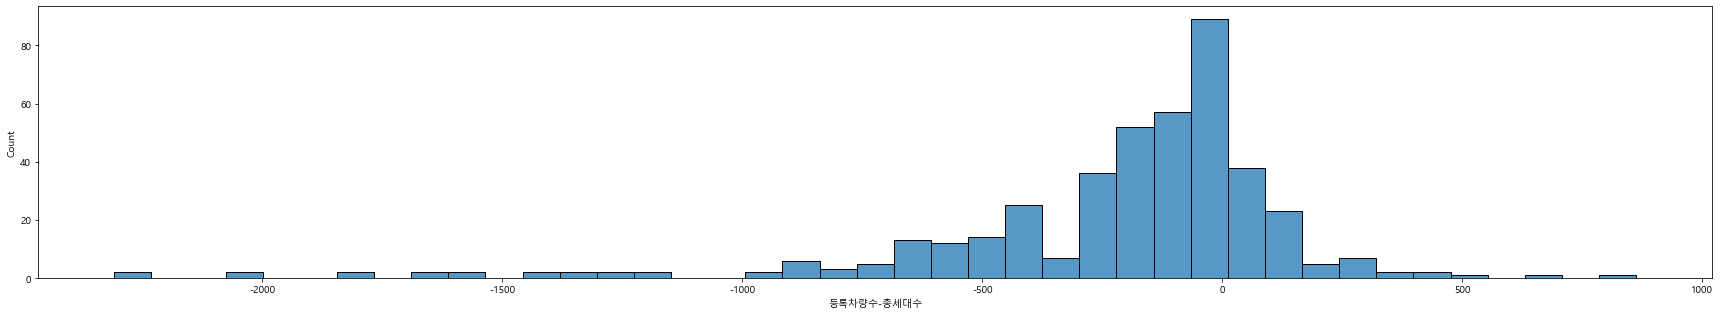

In [90]:
tmp = train[train['단지내주차면수']<987][['등록차량수','단지코드','지역','공급유형','총세대수','단지내주차면수']].drop_duplicates()
tmp['등록차량수-총세대수'] = tmp.apply(lambda x : x['등록차량수']-x['총세대수'],axis=1)
fig, ax = plt.subplots(figsize=(30,5))
sns.histplot(data=tmp,x='등록차량수-총세대수')

In [91]:
tmp = train[train['단지내주차면수']>=987][['등록차량수','단지코드','지역','공급유형','총세대수','단지내주차면수']].drop_duplicates()
tmp['등록차량수-총세대수'] = tmp.apply(lambda x : x['등록차량수']-x['총세대수'],axis=1)
tmp['cluster'] = tmp.apply(lambda x : 1 if x['등록차량수-총세대수']>0 else 0 ,axis=1)

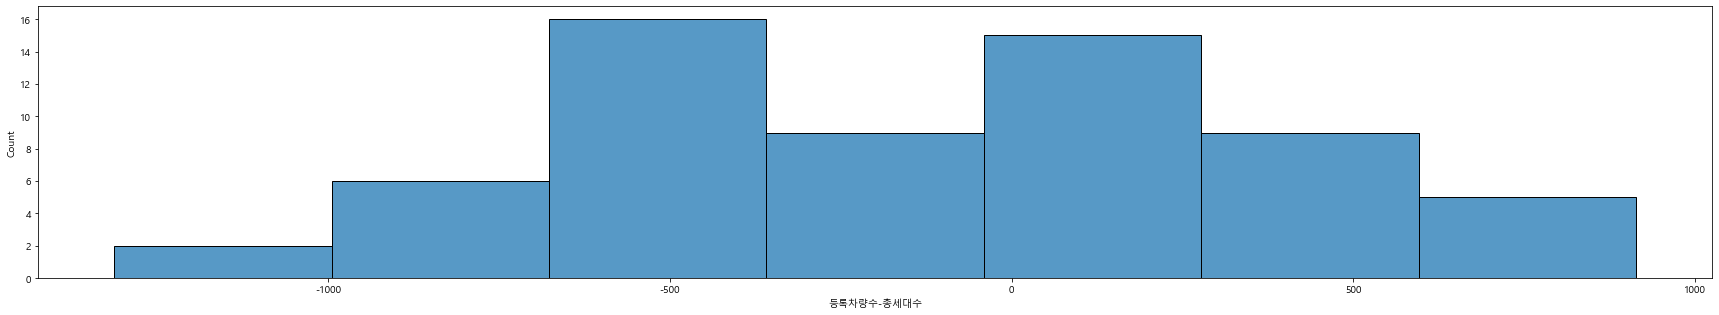

In [92]:
fig, ax = plt.subplots(figsize=(30,5))
sns.histplot(data=tmp,x='등록차량수-총세대수')

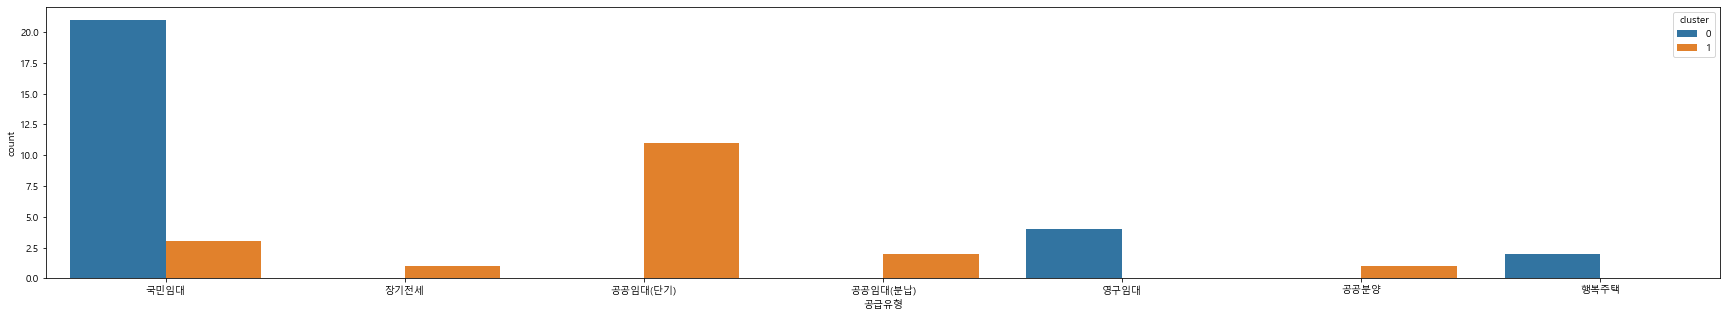

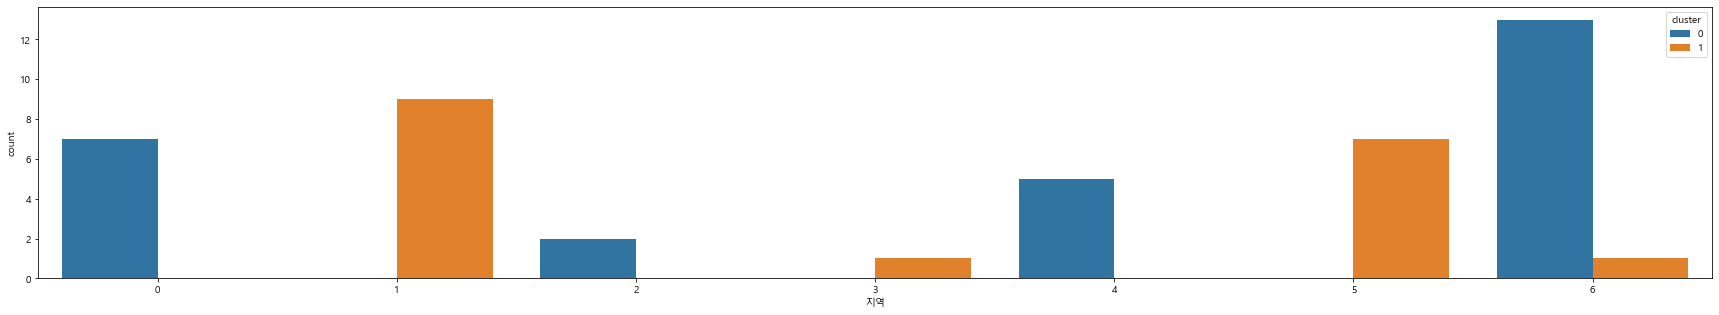

In [93]:
tmp = tmp[(tmp['등록차량수-총세대수']>200)|(tmp['등록차량수-총세대수']<-200)]
fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='공급유형',hue='cluster')

fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='지역',hue='cluster')

In [80]:
def areafunc(x):
    if x in ['제주특별자치도','경상남도','부산광역시']:
        return 0
    elif x in ['광주광역시','세종특별자치시','경상북도','전라북도','서울특별시']:
        return 1
    elif x in ['대구광역시']:
        return 2
    else: 
        return 3

In [81]:
tmp['지역'] = tmp['지역'].apply(lambda x : areafunc(x))

In [ ]:
print('파랑 : ',tmp[(tmp['지역']==3)&(tmp['cluster']==0)]['공급유형'].unique()) 
print('주황 : ',tmp[(tmp['지역']==3)&(tmp['cluster']==1)]['공급유형'].unique())

In [ ]:
print('파랑 : ',tmp[(tmp['지역']==2)&(tmp['cluster']==0)]['공급유형'].unique()) 
print('주황 : ',tmp[(tmp['지역']==2)&(tmp['cluster']==1)]['공급유형'].unique())

- '제주특별자치도','경상남도','부산광역시' : 0
- '광주광역시','세종특별자치시','경상북도','전라북도','서울특별시' :1
- 대구광역시 & (국민임대,영구임대) : 2 $\rightarrow$ 등록차량수<총세대수
- 대구광역시 & (공공임대(단기)) : 3 $\rightarrow$ 등록차량수>총세대수
- 경기도, 전라남도, 대전광역시, 충청북도 & (영구임대,행복주택) $\rightarrow$ 등록차량수<총세대수
- 경기도, 전라남도, 대전광역시, 충청북도 & (공공임대(단기),공공분양,공공임대(분납)) $\rightarrow$ 등록차량수>총세대수
- 경기도, 전라남도, 대전광역시, 충청북도 & (국민임대) $\rightarrow$ 모름

In [36]:
train_up = train_up.join(pd.get_dummies(train_up['지역'],prefix='area')).iloc[:,:-1]
test_up = test_up.join(pd.get_dummies(test_up['지역'],prefix='area')).iloc[:,:-1]

In [89]:
train_up[train_up['지역']==3][['총세대수','등록차량수','단지내주차면수']]

,총세대수,등록차량수,단지내주차면수
47,1124,1433.0,1201.0


## 3. 모델링

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

In [33]:
def fit(X_train, X_test, y_train, y_test, model):
    try:
        model.fit(X_train, y_train, verbose=False)
    except:
        model.fit(X_train, y_train)
    tst_pred = model.predict(X_test)
    error = mean_absolute_error(y_test,tst_pred)
    return model, tst_pred, error


def fit_models(X, y, models, cv=False):
    X = np.array(X.reset_index(drop=True))
    y = np.array(y.reset_index(drop=True))
    best_error = 10000
    best_tst_pred = 0
    best_model = ""
    if cv==False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
        for m in models:
            model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
            if best_error > error:
                best_error = error
                best_tst_pred = tst_pred
                best_model = model
    else:
        best_tst_idx = []
        kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
        for m in models:
            mae = []
            pred= []
            tst_idx = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
                mae.append(error)
                pred.append(tst_pred.tolist())
                tst_idx.append(test_index.tolist())
            cv_error = np.mean(mae)
            print(f"model:{str(m).split('(')[0]}\nMAE:{cv_error}")
            if best_error > cv_error:
                best_error = cv_error
                best_tst_pred = pred
                best_tst_idx = sum(tst_idx, [])
                best_model = model
    best_tst_pred = sum(best_tst_pred,[])
    print(best_tst_idx)
    best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
    try:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                                np.concatenate((y_train, y_test),axis=0), 
                                                verbose=False)
    except:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                        np.concatenate((y_train, y_test),axis=0))
    return best_model, best_tst_pred, best_error

### 1) train/test down

In [39]:
X = train_down.drop(columns=['단지코드','등록차량수'],axis=1)
X = pd.get_dummies(X, drop_first=True) 
X['지역_세종특별자치시'] = 0
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', '지역_경기도', '지역_경상남도', '지역_경상북도', '지역_광주광역시',
       '지역_대구광역시', '지역_대전광역시', '지역_부산광역시', '지역_서울특별시', '지역_세종특별자치시',
       '지역_울산광역시', '지역_전라남도', '지역_전라북도', '지역_제주특별자치도', '지역_충청남도', '지역_충청북도']]
y = train_down['등록차량수']

In [40]:
models = [CatBoostRegressor(random_state=2021)]
model_down,pred_down,error_down = fit_models(X, y, models, cv=True)
print('MAE : ',error_down)

model:<catboost.core.CatBoostRegressor object at 0x0000029C79C51A90>
MAE:105.69855840723085
[0, 1, 2, 6, 8, 9, 14, 15, 22, 28, 35, 36, 37, 38, 46, 48, 58, 64, 77, 88, 90, 95, 103, 104, 108, 111, 118, 124, 125, 132, 133, 136, 138, 140, 141, 149, 156, 163, 165, 177, 179, 182, 195, 200, 205, 206, 208, 209, 210, 213, 220, 222, 226, 227, 251, 252, 262, 268, 270, 271, 272, 281, 297, 301, 302, 306, 307, 313, 329, 334, 345, 351, 355, 3, 13, 26, 32, 41, 42, 50, 59, 60, 65, 68, 72, 73, 75, 76, 78, 79, 80, 93, 94, 98, 106, 110, 113, 127, 129, 131, 137, 139, 145, 147, 150, 158, 167, 171, 175, 180, 183, 184, 187, 190, 191, 192, 211, 215, 240, 243, 247, 256, 260, 264, 266, 273, 276, 278, 279, 280, 286, 287, 293, 295, 303, 314, 320, 321, 328, 331, 340, 342, 354, 356, 358, 359, 4, 10, 16, 18, 23, 24, 34, 43, 45, 51, 52, 53, 55, 56, 61, 62, 85, 86, 89, 92, 97, 115, 117, 122, 123, 130, 142, 148, 151, 161, 168, 170, 172, 186, 188, 199, 202, 204, 212, 214, 216, 224, 228, 232, 233, 235, 237, 242, 249, 250,

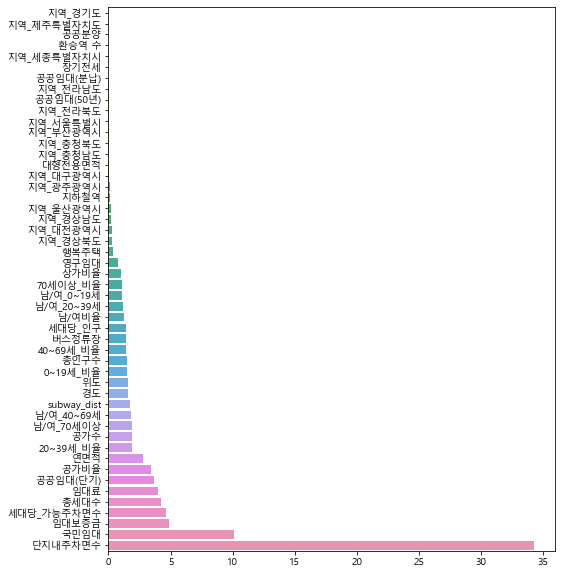

In [41]:
plt.figure(figsize=(8,10))
sns.barplot(y = X.columns[np.argsort(model_down.feature_importances_)], x = list(model_down.feature_importances_[np.argsort(model_down.feature_importances_)]))

### 2) train/test up

In [34]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor 
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as LGB
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR

In [37]:
X = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율'],axis=1)
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2','area_3', 'area_4', 'area_5']]
y = train_up['등록차량수']

models = [LinearRegression(), 
          PLSRegression(), 
          Ridge(random_state=2021),
          Lasso(random_state=2021), 
          ElasticNet(random_state=2021),
          SVR(),
          CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
          RandomForestRegressor(criterion="mae",random_state=2021),
          GradientBoostingRegressor(criterion="mae",random_state=2021),
          XGBRegressor(random_state=2021)]

model_up,pred_up,error_up = fit_models(X, y, models, cv=True)
print('MAE : ',error_up)

model:LinearRegression
MAE:612.3215637627181
model:PLSRegression
MAE:313.6278781610321
model:Ridge
MAE:302.4155600314934
model:Lasso
MAE:295.18288743110395
model:ElasticNet
MAE:323.6526453247646
model:SVR
MAE:365.85943769722235
model:<catboost.core.CatBoostRegressor object at 0x0000029C76168160>
MAE:270.73391846684234
model:RandomForestRegressor
MAE:301.51606060606065
model:GradientBoostingRegressor
MAE:310.54138311101593
model:XGBRegressor
MAE:286.6825516209458
[8, 11, 15, 28, 32, 34, 35, 36, 43, 46, 51, 53, 3, 4, 9, 13, 14, 19, 23, 25, 31, 41, 55, 2, 5, 10, 16, 17, 18, 20, 40, 48, 49, 50, 1, 6, 7, 12, 24, 26, 33, 37, 38, 39, 42, 0, 21, 22, 27, 29, 30, 44, 45, 47, 52, 54]
MAE :  270.73391846684234


In [50]:
print(model_up)

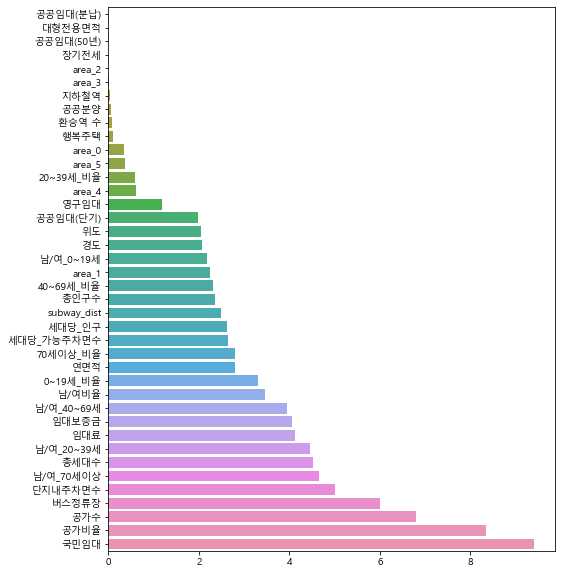

In [38]:
plt.figure(figsize=(8,10))
sns.barplot(y = X.columns[np.argsort(model_up.feature_importances_)], x = list(model_up.feature_importances_[np.argsort(model_up.feature_importances_)]))

In [42]:
(error_down*train_down.shape[0]+error_up*train_up.shape[0])/(train_down.shape[0]+train_up.shape[0])

127.8085587979922

## 4. Final prediction

In [43]:
col = ['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', '지역_경기도', '지역_경상남도', '지역_경상북도', '지역_광주광역시',
       '지역_대구광역시', '지역_대전광역시', '지역_부산광역시', '지역_서울특별시', '지역_세종특별자치시',
       '지역_울산광역시', '지역_전라남도', '지역_전라북도', '지역_제주특별자치도', '지역_충청남도', '지역_충청북도']

In [44]:
X_train = train_down.drop(columns=['단지코드','등록차량수'],axis=1)
X_train = pd.get_dummies(X_train, drop_first=True) 
X_train['지역_세종특별자치시'] = 0
X_train = X_train[col]
y_train = train_down['등록차량수']
X_test = test_down.drop(columns=['단지코드'],axis=1)
X_test = pd.get_dummies(X_test, drop_first=True) 
X_test['지역_서울특별시'] = 0
X_test = X_test[col]

In [45]:
cb_down = CatBoostRegressor(random_state=2021,verbose=False).fit(X_train,y_train)
pred_down = cb_down.predict(X_test)

In [46]:
col = ['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수',  '총인구수','세대당_인구','남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2','area_3', 'area_4', 'area_5'] # '총인구수',

In [48]:
X_train = train_up.drop(columns=['단지코드','등록차량수','지역'],axis=1)
X_train = X_train[col]
y_train = train_up['등록차량수']
X_test = test_up.drop(columns=['단지코드','지역'],axis=1)
X_test['area_3'] = 0
X_test['area_4'] = 0
X_test = X_test[col]

cb_up = Lasso(random_state=2021).fit(X_train,y_train)
pred_up = cb_up.predict(X_test)

In [49]:
def get_pred():
    res_down = pd.DataFrame()
    res_down['code'] = test_down['단지코드'].values
    res_down['num'] = pred_down
    res_up = pd.DataFrame()
    res_up['code'] = test_up['단지코드'].values
    res_up['num'] = pred_up 
    res = pd.concat([res_down,res_up],axis=0).reset_index(drop=True)
    return res_down, res_up, res

In [54]:
res2.columns = ['단지코드','96','y_pred']

In [55]:
res2 = res2.loc[res2['단지코드'].isin(test_up['단지코드'].values),:]

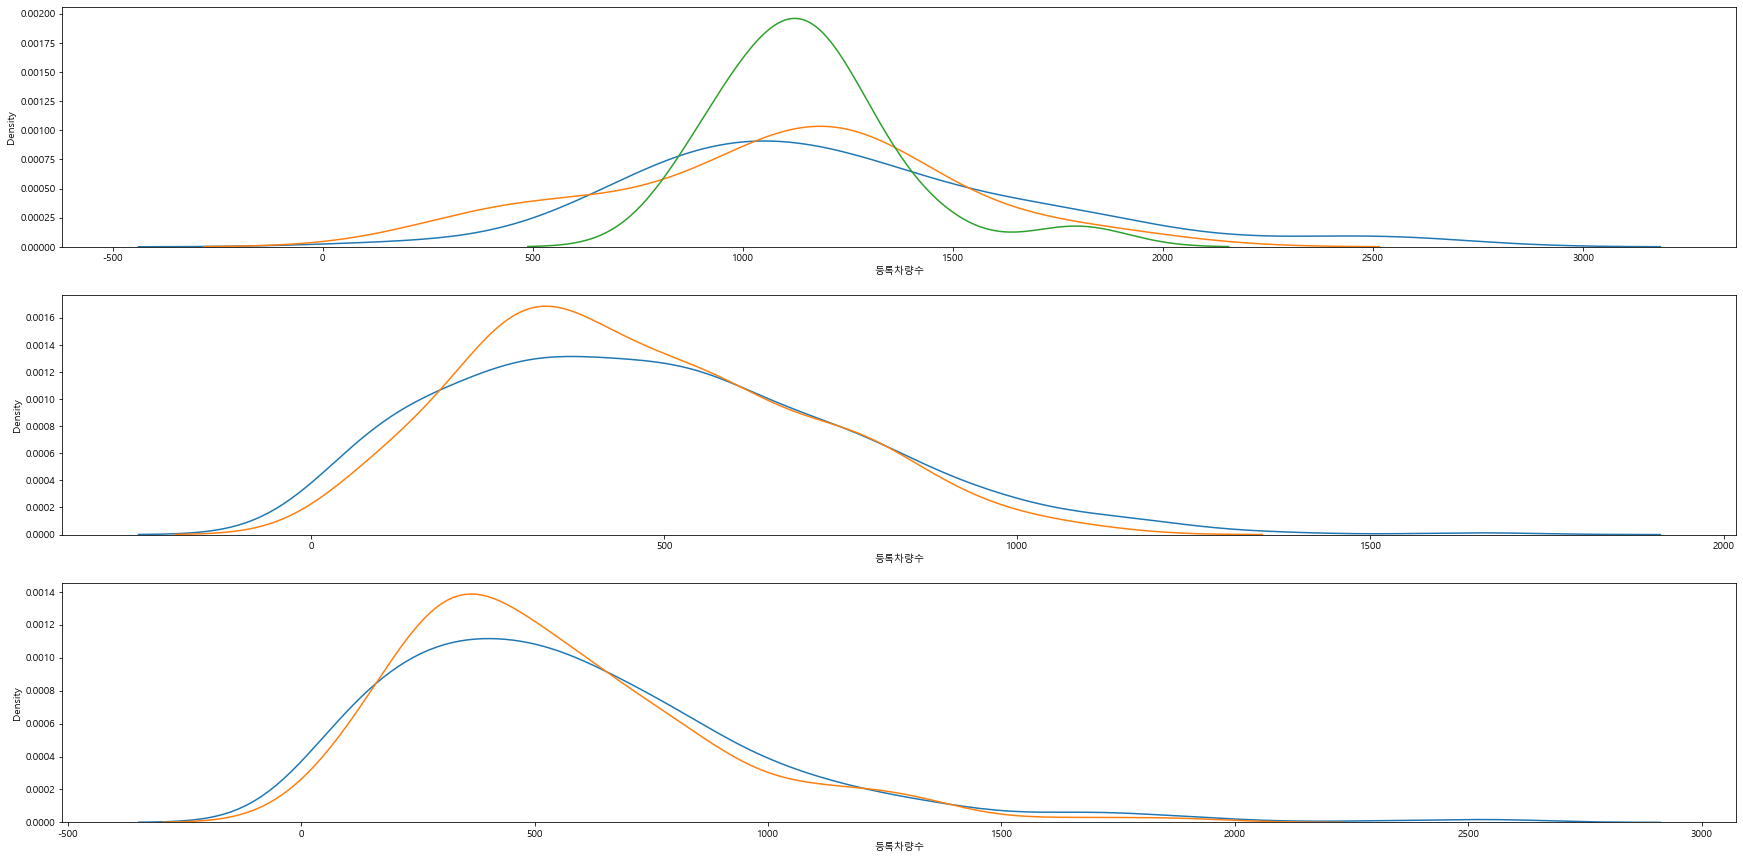

In [56]:
#ridge
fig, ax = plt.subplots(3,1,figsize=(30,15))
sns.kdeplot(data=train_up,x='등록차량수',ax=ax[0])
sns.kdeplot(data=get_pred()[1],x='num',ax=ax[0])
sns.kdeplot(data=res2,x='96',ax=ax[0])
sns.kdeplot(data=train_down,x='등록차량수',ax=ax[1])
sns.kdeplot(data=get_pred()[0],x='num',ax=ax[1])
sns.kdeplot(data=train_one,x='등록차량수',ax=ax[2])
sns.kdeplot(data=get_pred()[2],x='num',ax=ax[2])

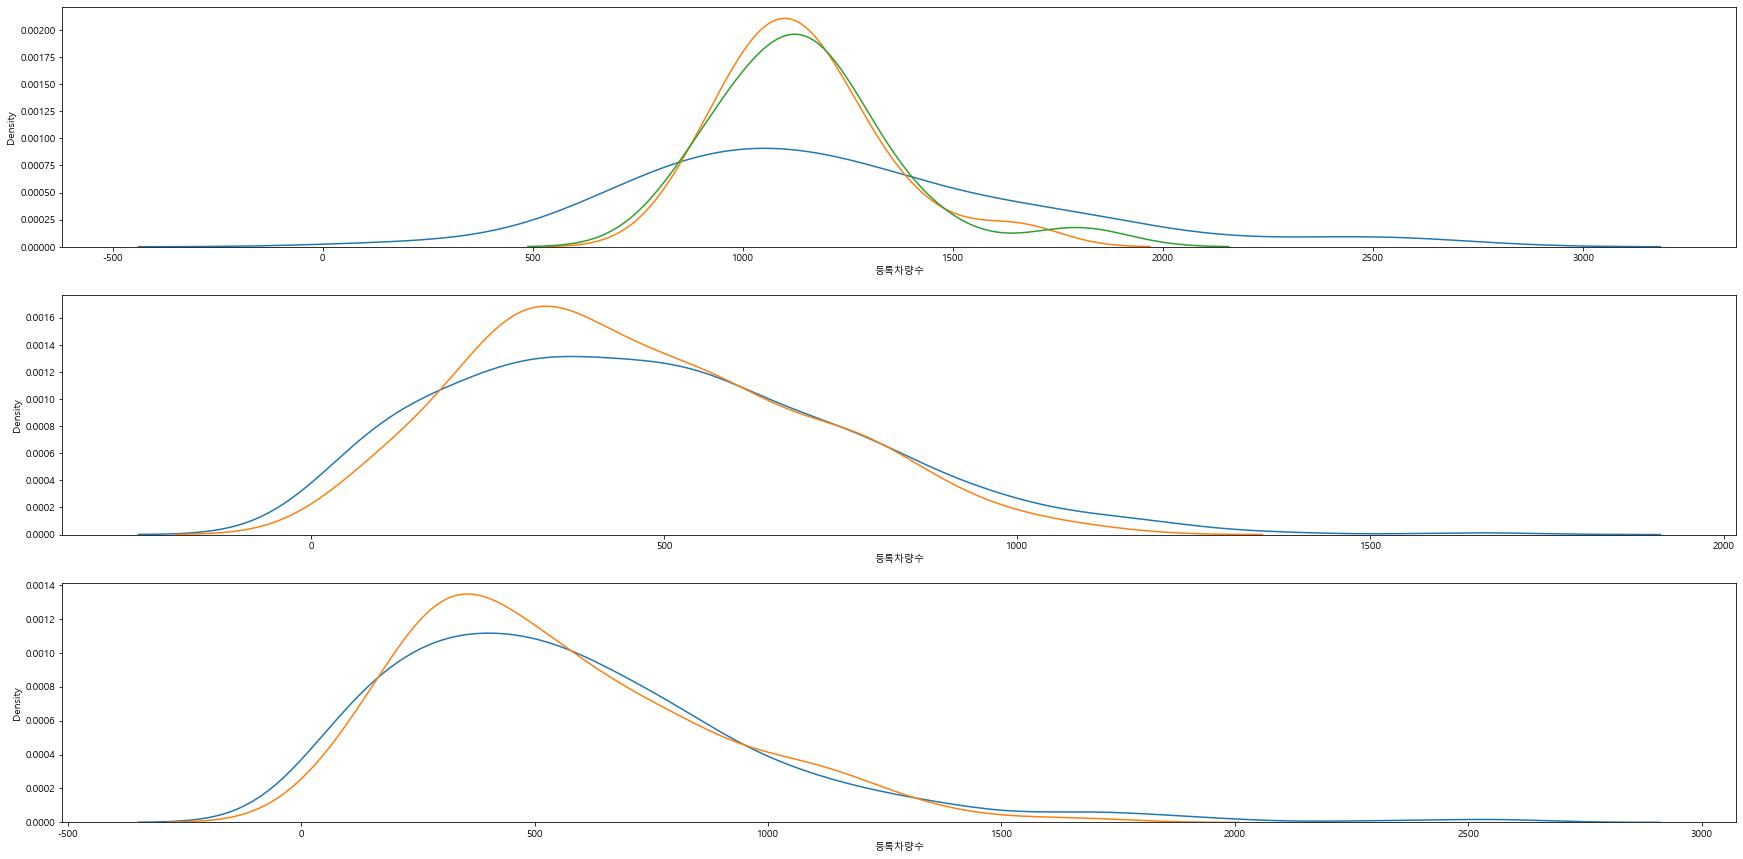

In [53]:
#CATBOOST
fig, ax = plt.subplots(3,1,figsize=(30,15))
sns.kdeplot(data=train_up,x='등록차량수',ax=ax[0])
sns.kdeplot(data=get_pred()[1],x='num',ax=ax[0])
sns.kdeplot(data=res2,x='96',ax=ax[0])
sns.kdeplot(data=train_down,x='등록차량수',ax=ax[1])
sns.kdeplot(data=get_pred()[0],x='num',ax=ax[1])
sns.kdeplot(data=train_one,x='등록차량수',ax=ax[2])
sns.kdeplot(data=get_pred()[2],x='num',ax=ax[2])

- '제주특별자치도','경상남도','부산광역시' : 0 →  등록차량수<총세대수
- '광주광역시','세종특별자치시','경상북도','전라북도','서울특별시' :1 →  등록차량수>총세대수
- 대구광역시 & (국민임대,영구임대) : 2  →  등록차량수<총세대수
- 대구광역시 & (공공임대(단기)) : 3  →  등록차량수>총세대수
- 경기도, 전라남도, 대전광역시, 충청북도 & (영구임대,행복주택)  →  등록차량수<총세대수
- 경기도, 전라남도, 대전광역시, 충청북도 & (공공임대(단기),공공분양,공공임대(분납))  →  등록차량수>총세대수
- 경기도, 전라남도, 대전광역시, 충청북도 & (국민임대)  →  모름

In [57]:
test_up['y_pred'] = pred_up

In [72]:
tmp = pd.merge(test_up[['지역','총세대수','y_pred','단지코드']],res2[['단지코드','96']],on='단지코드',how='inner')

In [70]:
train_up[train_up['지역']==0][['단지코드','총세대수','등록차량수']]

,단지코드,총세대수,등록차량수
2,C1672,1350,873.0
3,C1430,1533,839.0
4,C1833,1364,1001.0
7,C2000,1300,795.0
27,C1649,1047,1214.0
30,C2377,1105,579.0
39,C1320,1696,924.0
40,C1326,1934,1153.0
49,C1357,908,995.0


In [73]:
tmp[tmp['지역']==0][['단지코드','총세대수','y_pred','96']] #등록차량수 < 총세대수 CATBOOST

,단지코드,총세대수,y_pred,96
4,C1152,1301,605.218207,847.316183
7,C1617,1008,603.131470,1067.296112
9,C2028,1267,1273.109946,1060.469848
12,C2076,1385,1259.298245,1023.262869


In [74]:
tmp[tmp['지역']==1][['단지코드','총세대수','y_pred','96']]

,단지코드,총세대수,y_pred,96
3,C1794,1349,1112.146391,1048.372040
5,C2555,1442,1641.692013,1440.366369
11,C1521,1414,1382.189341,1178.800599
13,C2473,1147,1285.542854,1191.698222


In [76]:
train_up[train_up['지역']==2][['단지코드','총세대수','등록차량수']]

,단지코드,총세대수,등록차량수
25,C1969,1366,886.0


In [75]:
tmp[tmp['지역']==2][['단지코드','총세대수','y_pred','96']]

,단지코드,총세대수,y_pred,96
16,C1692,1390,368.44202,969.00496


## 5. 기존 score와 비교 및 제출

In [51]:
def submit():
    res = get_pred()[2]
    res.loc[147,:] = ['C1327',0]
    res.loc[148,:] = ['C2335',0]
    res.loc[149,:] = ['C2675',0]
    return res

In [64]:
sub = submit()
sub.to_csv("result/result_cat.csv",index=False)

In [52]:
def score(mse):
    score = pd.read_csv("result/MAE_"+str(mse)+".csv")
    score = pd.merge(score,get_pred()[2],on='code',how='inner')
    val = test_up['단지코드'].values
    score_up = score.loc[score['code'].isin(val),:]
    score_down = score.loc[-score['code'].isin(val),:] #y가 새롭게 예측
    mae = mean_absolute_error(score['num_x'],score['num_y'])
    mae_up = mean_absolute_error(score_up['num_x'],score_up['num_y'])
    mae_down = mean_absolute_error(score_down['num_x'],score_down['num_y'])
    print('전체 MAE : ',mae)
    print('큰 영역 MAE : ',mae_up)
    print('작은 영역 MAE : ',mae_down)
    return score

In [53]:
res2 = score(96)

전체 MAE :  28.79592366680629
큰 영역 MAE :  222.78951468529044
작은 영역 MAE :  3.68594044175552e-14


In [200]:
res1 = score(98)

전체 MAE :  22.032000169583043
큰 영역 MAE :  170.45810657519493
작은 영역 MAE :  3.0753177782116836e-14


In [201]:
res3 = score(99)

전체 MAE :  52.57346961219873
큰 영역 MAE :  186.5983580643478
작은 영역 MAE :  32.67915023258284


In [202]:
res4 = score(100)

전체 MAE :  55.38194228735342
큰 영역 MAE :  189.89498342255933
작은 영역 MAE :  35.415162743846295
